Approximate the complete design space using only the sampled conditions and use a random subset of samples to train the NN to predict switching. Query the remaining set of samples to find conditions the NN predicts to have improved switching. Update model on selected set and repeat.

In [1]:
# SET SIMULATION PARAMETERS 

# initial number of training conditions 
n_init = 10 

# number of pairs of light conditions to apply to each strain  
n_design = 10

# rounds of design, test, learn 
n_rounds =  5

# number of trials 
n_trials = 10

In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import itertools 
from scipy.special import comb

from scipy.stats import linregress

from parabola.laplace_nn2 import *

from tqdm import tqdm

# set random seed 
np.random.seed(123)

In [3]:
# import data 
df_0 = pd.read_csv("data/universal_df.csv")
df_1 = pd.read_csv("data/design_1_df.csv")
df_2 = pd.read_csv("data/design_2_df.csv")
df = pd.concat((df_0, df_1, df_2))

# define features and response
features = df.columns.values[:3]
response = df.columns.values[3:]

# matrix of inputs and responses 
X = np.array(df[features].values, float)
Y = np.array(df[response].values, float)

# scale Y so that max value is 1
Y_max = np.nanmax(Y, 0)
Y = Y / Y_max

In [4]:
# interpolate missing data using NN trained on everything 
n_inputs = len(features)
n_hidden = 16
n_outputs = len(response)

ffnn = FFNN(n_inputs, n_hidden, n_outputs)
print(f"Number of model parameters: {ffnn.n_params}")

# fit NN
ffnn.fit(X, Y)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Number of model parameters: 387
Updating precision...
Evidence -372.425
Updating precision...
Evidence 1428.518
Updating precision...
Evidence 2701.498
Updating precision...
Evidence 3283.473
Updating precision...
Evidence 3429.001
Updating precision...
Evidence 3442.010
Updating precision...
Evidence 3458.727
Updating precision...
Evidence 3460.382
Pass count  1


In [5]:
# import design space
df = pd.read_csv("data/Optogenetics_design_space_mini.csv")
X = df[features].values

In [6]:
# update Y with NN fit 
Y = ffnn.predict_point(X)

# update dataframe with interpolated data
df[response] = Y

In [7]:
# compute product between all elements of a given vector 
def prod(d):
    # matrix where element ij = v_i * v_j 
    diff_mat = vmap(lambda d1: vmap(lambda d2: d1 * d2)(d))(d)
    return diff_mat.ravel()

# function to apply product of differences to set of vectors
batch_prod = jit(vmap(prod))

# given measured outcomes from two light conditions, compute min product in differences
@jit
def measured_obj(y1, y2):
    return -jnp.nanmin(prod(y1-y2))

# objective: given two light inputs, compute min product in differences in efficacies 
def obj_params(params, ffnn, U):
    u1 = U[:, :3]
    u2 = U[:, 3:]
    
    # predict efficacies of strains due to light input 1
    y1 = ffnn.predict_point_params(u1, params)
    
    # predict efficacies of strains due to light input 2
    y2 = ffnn.predict_point_params(u2, params)
    
    # return largest product of differences for each sample 
    # should be negative, so multiply by negative 1 
    return -jnp.min(batch_prod(y1 - y2), 1)

def sample(mu, cov):        
    
    # cholesky factorization of covariance
    L = np.linalg.cholesky(cov)
    
    # standard normal random vector
    z = np.random.randn(len(mu))
    
    # transform so that sample has E[s] = mu, cov[s] = cov
    return mu + np.dot(z, L.T)

In [8]:
# return indeces of optimal samples
def search_Thompson(ffnn, D, N, batch_size = 256):

    # make a copy 
    data = np.copy(D)
    
    # determine number of samples to search over
    n_samples = data.shape[0]
    batch_size = min([n_samples, batch_size])
    
    # init selected set
    best_samples = []
    while len(best_samples) < N:
    
        # sample params from posterior
        params = sample(ffnn.params, ffnn.Ainv)
    
        # exploitation objective evaluations 
        f_P = []
        for batch_inds in tqdm(np.array_split(np.arange(n_samples), n_samples//batch_size)):
            # make predictions on data
            f_P.append(obj_params(params, ffnn, data[batch_inds]))
        f_P = jnp.concatenate(f_P).ravel()

        # initialize with sample that maximizes objective
        sample_index = np.nanargmax(f_P).item()
        if sample_index not in best_samples:
            # pick sample and remove from selection
            best_samples.append(sample_index)
            data[sample_index, :] = np.nan
            print(f"Picked experiment {len(best_samples)} out of {N}, sample {sample_index}")

    return best_samples

In [9]:
# create design space of all pairs of light inputs 
n_light = df.shape[0]

# there are n_light choose 2 different pairs 
n_cond = comb(n_light, 2)
D = np.zeros([int(n_cond), 2*len(features)])

# init dictionary to map design index to rows of data set 
data_dict = {}

# compute measured objective for all light pairs
objectives = []

# populate matrix of input combinations 
for k, (i, j) in tqdm(enumerate(itertools.combinations(range(n_light), 2)), total=n_cond):
    data_dict[k] = [i,j]
    
    # light inputs 
    u1 = X[i] # df.iloc[i][features].values
    u2 = X[j] # df.iloc[j][features].values
    D[k, :3] = u1
    D[k, 3:] = u2
    
    # measured response 
    y1 = Y[i] # df.iloc[i][response].values
    y2 = Y[j] # df.iloc[j][response].values
    objectives.append(measured_obj(y1, y2))
    
# convert to numpy array
objectives = np.array(objectives)

100%|███████████████████████████████| 165600/165600.0 [01:37<00:00, 1694.30it/s]


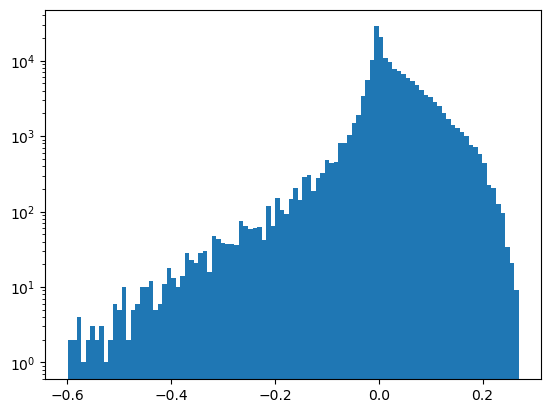

165600

In [10]:
plt.hist(objectives, bins=100)
plt.yscale("log")
plt.show()
len(objectives)

In [11]:
np.nanmax(objectives)

0.2690671

In [12]:
# generate a list of random indices for starting optimization
randinds_list = [np.random.choice(np.arange(X.shape[0]), n_init, replace=False) for _ in range(n_trials)]

In [13]:
# init dataframe to keep track of optimization status
df_results = pd.DataFrame()

# repeat process several times
for trial in np.arange(n_trials):

    # init with randomly selected set of conditions 
    randinds = randinds_list[trial]
    X_train, Y_train = X[randinds], Y[randinds]

    # init objectives
    # populate matrix of input combinations 
    n_cond = comb(n_init, 2)
    init_objectives = []
    for k, (i, j) in tqdm(enumerate(itertools.combinations(range(n_init), 2)), total=comb(n_init, 2)):
        init_objectives.append(measured_obj(Y_train[i], Y_train[j]))

    # initialize list of best found objectives
    best_objective = [np.nanmax(init_objectives)]
    print("Starting with best value", best_objective[-1])

    # loop through rounds of design, test, learn
    for _ in np.arange(n_rounds):
        
        # init model 
        n_inputs = len(features)
        n_hidden = 8
        n_outputs = len(response)
        ffnn = FFNN(n_inputs, n_hidden, n_outputs)

        # fit NN
        ffnn.fit(X_train, Y_train)

        # design new experiment 
        optimized_samples = search_Thompson(ffnn, D, n_design)
        
        # collect new data and evaluate performance of selected samples 
        sampled_objectives = []
        X_new = []
        Y_new = []
        for k in optimized_samples:
            i, j = data_dict[k]
            X_new.append(X[i])
            X_new.append(X[j])
            Y_new.append(Y[i])
            Y_new.append(Y[j])
            y1 = Y[i]
            y2 = Y[j]
            sampled_objectives.append(measured_obj(y1, y2))
        best_objective.append(np.max([np.max(best_objective), np.nanmax(np.array(sampled_objectives))]))
        print("DTL progress", best_objective)

        # append new data to train data
        X_new = np.stack(X_new)
        Y_new = np.stack(Y_new)
        X_train = np.concatenate((X_train, X_new))
        Y_train = np.concatenate((Y_train, Y_new))

    # save results
    df_results[trial] = best_objective

100%|███████████████████████████████████████| 45/45.0 [00:00<00:00, 1203.32it/s]


Starting with best value 0.10312048
Updating precision...
Evidence -74.102
Updating precision...
Evidence 40.336
Updating precision...
Evidence 133.865
Updating precision...
Evidence 174.309
Updating precision...
Evidence 203.532
Updating precision...
Evidence 226.013
Updating precision...
Evidence 241.424
Updating precision...
Evidence 251.714
Updating precision...
Evidence 259.148
Updating precision...
Evidence 264.645
Updating precision...
Evidence 268.294
Updating precision...
Evidence 270.498
Updating precision...
Evidence 273.162
Updating precision...
Evidence 270.716
Fail count  1
Updating precision...
Evidence 270.248
Fail count  2
Updating precision...
Evidence 269.775
Fail count  3
Updating precision...
Evidence 268.123
Fail count  4
Updating precision...
Evidence 265.947
Fail count  5
Updating precision...
Evidence 263.312
Fail count  6
Updating precision...
Evidence 261.809
Fail count  7
Updating precision...
Evidence 260.140
Fail count  8
Updating precision...
Evidence 259

100%|███████████████████████████████████████| 646/646 [00:00<00:00, 1348.19it/s]


Picked experiment 1 out of 10, sample 29956


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3210.67it/s]


Picked experiment 2 out of 10, sample 5129


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3240.74it/s]


Picked experiment 3 out of 10, sample 114432


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3546.64it/s]


Picked experiment 4 out of 10, sample 128179


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3504.99it/s]


Picked experiment 5 out of 10, sample 114496


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3413.19it/s]


Picked experiment 6 out of 10, sample 163646


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3483.92it/s]


Picked experiment 7 out of 10, sample 69449


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3454.33it/s]


Picked experiment 8 out of 10, sample 20599


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3622.08it/s]


Picked experiment 9 out of 10, sample 163708


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3319.12it/s]


Picked experiment 10 out of 10, sample 163520
DTL progress [0.10312048, 0.16505004]
Updating precision...
Evidence -155.663
Updating precision...
Evidence 253.112
Updating precision...
Evidence 574.708
Updating precision...
Evidence 811.671
Updating precision...
Evidence 959.175
Updating precision...
Evidence 1038.051
Updating precision...
Evidence 1098.398
Updating precision...
Evidence 1138.157
Updating precision...
Evidence 1156.873
Updating precision...
Evidence 1168.005
Updating precision...
Evidence 1173.130
Updating precision...
Evidence 1176.424
Updating precision...
Evidence 1177.811
Updating precision...
Evidence 1179.135
Updating precision...
Evidence 1180.665
Updating precision...
Evidence 1181.858
Updating precision...
Evidence 1182.235
Pass count  1


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 2451.02it/s]


Picked experiment 1 out of 10, sample 113208


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3296.29it/s]


Picked experiment 2 out of 10, sample 113144


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3457.39it/s]


Picked experiment 3 out of 10, sample 113272


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3396.11it/s]


Picked experiment 4 out of 10, sample 90493


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3701.28it/s]


Picked experiment 5 out of 10, sample 63618


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3584.62it/s]


Picked experiment 6 out of 10, sample 112884


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3539.06it/s]


Picked experiment 7 out of 10, sample 113080


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3538.10it/s]


Picked experiment 8 out of 10, sample 112948


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3549.15it/s]


Picked experiment 9 out of 10, sample 112820


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3349.74it/s]


Picked experiment 10 out of 10, sample 131604
DTL progress [0.10312048, 0.16505004, 0.17254446]
Updating precision...
Evidence -172.457
Updating precision...
Evidence 697.613
Updating precision...
Evidence 1396.120
Updating precision...
Evidence 1878.479
Updating precision...
Evidence 2163.167
Updating precision...
Evidence 2320.052
Updating precision...
Evidence 2378.616
Updating precision...
Evidence 2392.251
Updating precision...
Evidence 2395.052
Updating precision...
Evidence 2396.911
Pass count  1


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 2410.33it/s]


Picked experiment 1 out of 10, sample 92363


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3542.43it/s]


Picked experiment 2 out of 10, sample 147307


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3534.46it/s]


Picked experiment 3 out of 10, sample 92299


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3625.93it/s]


Picked experiment 4 out of 10, sample 92745


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3523.23it/s]


Picked experiment 5 out of 10, sample 156092


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3408.72it/s]


Picked experiment 6 out of 10, sample 93126


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3916.80it/s]


Picked experiment 7 out of 10, sample 93506


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3705.34it/s]


Picked experiment 8 out of 10, sample 92681


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3507.20it/s]


Picked experiment 9 out of 10, sample 93062


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3561.19it/s]


Picked experiment 10 out of 10, sample 95765
DTL progress [0.10312048, 0.16505004, 0.17254446, 0.21103583]
Updating precision...
Evidence -195.586
Updating precision...
Evidence 1242.932
Updating precision...
Evidence 2359.449
Updating precision...
Evidence 3064.900
Updating precision...
Evidence 3353.452
Updating precision...
Evidence 3454.427
Updating precision...
Evidence 3473.498
Updating precision...
Evidence 3476.624
Pass count  1


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 2337.51it/s]


Picked experiment 1 out of 10, sample 35266


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3499.76it/s]


Picked experiment 2 out of 10, sample 39820


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3731.63it/s]


Picked experiment 3 out of 10, sample 157588


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3405.31it/s]


Picked experiment 4 out of 10, sample 546


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3527.74it/s]


Picked experiment 5 out of 10, sample 35257


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3519.03it/s]


Picked experiment 6 out of 10, sample 35767


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3480.48it/s]


Picked experiment 7 out of 10, sample 10716


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3386.32it/s]


Picked experiment 8 out of 10, sample 17331


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3578.72it/s]


Picked experiment 9 out of 10, sample 35776


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3500.18it/s]


Picked experiment 10 out of 10, sample 36285
DTL progress [0.10312048, 0.16505004, 0.17254446, 0.21103583, 0.22082894]
Updating precision...
Evidence -190.998
Updating precision...
Evidence 1849.560
Updating precision...
Evidence 3443.136
Updating precision...
Evidence 4426.191
Updating precision...
Evidence 4724.351
Updating precision...
Evidence 4770.022
Updating precision...
Evidence 4796.176
Updating precision...
Evidence 4846.092
Updating precision...
Evidence 4864.625
Updating precision...
Evidence 4870.218
Updating precision...
Evidence 4873.604
Pass count  1


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 2254.50it/s]


Picked experiment 1 out of 10, sample 34746


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3501.59it/s]


Picked experiment 2 out of 10, sample 73765


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3531.92it/s]


Picked experiment 3 out of 10, sample 34755


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3503.24it/s]


Picked experiment 4 out of 10, sample 34663


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3508.21it/s]


Picked experiment 5 out of 10, sample 34737


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3439.56it/s]


Picked experiment 6 out of 10, sample 92436


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3511.02it/s]


Picked experiment 7 out of 10, sample 29836


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3513.25it/s]


Picked experiment 8 out of 10, sample 34691


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3509.45it/s]


Picked experiment 9 out of 10, sample 34672


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3515.12it/s]


Picked experiment 10 out of 10, sample 92427
DTL progress [0.10312048, 0.16505004, 0.17254446, 0.21103583, 0.22082894, 0.250221]


100%|███████████████████████████████████████| 45/45.0 [00:00<00:00, 1610.22it/s]


Starting with best value 0.17129481
Updating precision...
Evidence -77.174
Updating precision...
Evidence 30.433
Updating precision...
Evidence 90.523
Updating precision...
Evidence 136.527
Updating precision...
Evidence 173.087
Updating precision...
Evidence 197.798
Updating precision...
Evidence 209.747
Updating precision...
Evidence 218.478
Updating precision...
Evidence 224.003
Updating precision...
Evidence 227.480
Updating precision...
Evidence 230.077
Updating precision...
Evidence 229.170
Fail count  1
Updating precision...
Evidence 223.974
Fail count  2
Updating precision...
Evidence 222.562
Fail count  3
Updating precision...
Evidence 222.322
Fail count  4
Updating precision...
Evidence 222.726
Updating precision...
Evidence 223.589
Updating precision...
Evidence 223.565
Pass count  1
Fail count  5


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 2234.11it/s]


Picked experiment 1 out of 10, sample 34765


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3502.12it/s]


Picked experiment 2 out of 10, sample 5695


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3167.19it/s]


Picked experiment 3 out of 10, sample 5137


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3485.05it/s]


Picked experiment 4 out of 10, sample 48393


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3518.53it/s]


Picked experiment 5 out of 10, sample 35028


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3443.21it/s]


Picked experiment 6 out of 10, sample 163646


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3541.33it/s]


Picked experiment 7 out of 10, sample 95465


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3555.66it/s]


Picked experiment 8 out of 10, sample 569


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3616.15it/s]


Picked experiment 9 out of 10, sample 130564


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3759.34it/s]


Picked experiment 10 out of 10, sample 34728
DTL progress [0.17129481, 0.17129481]
Updating precision...
Evidence -148.184
Updating precision...
Evidence 227.362
Updating precision...
Evidence 522.425
Updating precision...
Evidence 734.133
Updating precision...
Evidence 883.334
Updating precision...
Evidence 988.490
Updating precision...
Evidence 1046.182
Updating precision...
Evidence 1068.635
Updating precision...
Evidence 1075.236
Updating precision...
Evidence 1077.178
Updating precision...
Evidence 1078.609
Updating precision...
Evidence 1079.238
Pass count  1


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 2197.52it/s]


Picked experiment 1 out of 10, sample 39820


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3526.10it/s]


Picked experiment 2 out of 10, sample 62


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3715.95it/s]


Picked experiment 3 out of 10, sample 29692


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3597.76it/s]


Picked experiment 4 out of 10, sample 29693


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3533.35it/s]


Picked experiment 5 out of 10, sample 163636


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3708.65it/s]


Picked experiment 6 out of 10, sample 59062


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3519.66it/s]


Picked experiment 7 out of 10, sample 53


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3822.08it/s]


Picked experiment 8 out of 10, sample 30212


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3545.41it/s]


Picked experiment 9 out of 10, sample 20553


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3535.87it/s]


Picked experiment 10 out of 10, sample 30213
DTL progress [0.17129481, 0.17129481, 0.21516216]
Updating precision...
Evidence -176.709
Updating precision...
Evidence 668.451
Updating precision...
Evidence 1339.760
Updating precision...
Evidence 1810.455
Updating precision...
Evidence 2091.846
Updating precision...
Evidence 2195.208
Updating precision...
Evidence 2211.958
Updating precision...
Evidence 2214.465
Updating precision...
Evidence 2214.881
Pass count  1


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 2271.72it/s]


Picked experiment 1 out of 10, sample 64105


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3531.69it/s]


Picked experiment 2 out of 10, sample 113908


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3519.00it/s]


Picked experiment 3 out of 10, sample 64096


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3523.65it/s]


Picked experiment 4 out of 10, sample 33216


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3452.74it/s]


Picked experiment 5 out of 10, sample 90889


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3471.53it/s]


Picked experiment 6 out of 10, sample 90880


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3452.49it/s]


Picked experiment 7 out of 10, sample 33225


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3575.66it/s]


Picked experiment 8 out of 10, sample 64087


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3411.33it/s]


Picked experiment 9 out of 10, sample 90898


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3605.66it/s]


Picked experiment 10 out of 10, sample 34400
DTL progress [0.17129481, 0.17129481, 0.21516216, 0.21877912]
Updating precision...
Evidence -230.570
Updating precision...
Evidence 1040.456
Updating precision...
Evidence 2194.914
Updating precision...
Evidence 2970.720
Updating precision...
Evidence 3295.082
Updating precision...
Evidence 3353.817
Updating precision...
Evidence 3362.704
Updating precision...
Evidence 3365.469
Pass count  1


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 2097.37it/s]


Picked experiment 1 out of 10, sample 111633


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3494.01it/s]


Picked experiment 2 out of 10, sample 83365


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3440.37it/s]


Picked experiment 3 out of 10, sample 114549


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3475.42it/s]


Picked experiment 4 out of 10, sample 82959


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3458.79it/s]


Picked experiment 5 out of 10, sample 54895


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3553.26it/s]


Picked experiment 6 out of 10, sample 82552


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3512.24it/s]


Picked experiment 7 out of 10, sample 162835


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3443.72it/s]


Picked experiment 8 out of 10, sample 114558


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3494.42it/s]


Picked experiment 9 out of 10, sample 34272


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3472.35it/s]


Picked experiment 10 out of 10, sample 163636
DTL progress [0.17129481, 0.17129481, 0.21516216, 0.21877912, 0.24573894]
Updating precision...
Evidence -224.163
Updating precision...
Evidence 1713.347
Updating precision...
Evidence 3319.867
Updating precision...
Evidence 4289.955
Updating precision...
Evidence 4586.753
Updating precision...
Evidence 4621.807
Updating precision...
Evidence 4626.831
Updating precision...
Evidence 4631.336
Pass count  1


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 2458.04it/s]


Picked experiment 1 out of 10, sample 34272


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3493.25it/s]


Picked experiment 2 out of 10, sample 95838


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3138.70it/s]


Picked experiment 3 out of 10, sample 82552


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3484.94it/s]


Picked experiment 4 out of 10, sample 92427


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3511.96it/s]


Picked experiment 5 out of 10, sample 77590


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3487.06it/s]


Picked experiment 6 out of 10, sample 92809


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3607.86it/s]


Picked experiment 7 out of 10, sample 93190


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3488.40it/s]


Picked experiment 8 out of 10, sample 95829


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3552.69it/s]


Picked experiment 9 out of 10, sample 96202


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3516.50it/s]


Picked experiment 10 out of 10, sample 34273
DTL progress [0.17129481, 0.17129481, 0.21516216, 0.21877912, 0.24573894, 0.24573894]


100%|███████████████████████████████████████| 45/45.0 [00:00<00:00, 1661.26it/s]


Starting with best value 0.2283367
Updating precision...
Evidence -76.685
Updating precision...
Evidence 29.838
Updating precision...
Evidence 108.406
Updating precision...
Evidence 164.218
Updating precision...
Evidence 200.951
Updating precision...
Evidence 225.411
Updating precision...
Evidence 241.193
Updating precision...
Evidence 247.810
Updating precision...
Evidence 252.100
Updating precision...
Evidence 253.592
Updating precision...
Evidence 255.224
Updating precision...
Evidence 256.720
Updating precision...
Evidence 256.375
Fail count  1
Updating precision...
Evidence 256.920
Updating precision...
Evidence 256.389
Fail count  2
Updating precision...
Evidence 255.247
Fail count  3
Updating precision...
Evidence 254.721
Fail count  4
Updating precision...
Evidence 253.430
Fail count  5
Updating precision...
Evidence 252.846
Fail count  6
Updating precision...
Evidence 251.850
Fail count  7
Updating precision...
Evidence 251.075
Fail count  8
Updating precision...
Evidence 250.

100%|███████████████████████████████████████| 646/646 [00:00<00:00, 2364.84it/s]


Picked experiment 1 out of 10, sample 34765


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3677.00it/s]


Picked experiment 2 out of 10, sample 34774


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3565.83it/s]


Picked experiment 3 out of 10, sample 25412


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3510.24it/s]


Picked experiment 4 out of 10, sample 20608


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3404.51it/s]


Picked experiment 5 out of 10, sample 34775


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3468.70it/s]


Picked experiment 6 out of 10, sample 34720


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3446.39it/s]


Picked experiment 7 out of 10, sample 30138


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3433.44it/s]


Picked experiment 8 out of 10, sample 34783


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3374.06it/s]


Picked experiment 9 out of 10, sample 20598


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3461.59it/s]


Picked experiment 10 out of 10, sample 30065
DTL progress [0.2283367, 0.2283367]
Updating precision...
Evidence -135.648
Updating precision...
Evidence 281.338
Updating precision...
Evidence 584.297
Updating precision...
Evidence 805.973
Updating precision...
Evidence 971.281
Updating precision...
Evidence 1088.656
Updating precision...
Evidence 1157.629
Updating precision...
Evidence 1188.176
Updating precision...
Evidence 1196.609
Updating precision...
Evidence 1198.182
Updating precision...
Evidence 1198.418
Pass count  1


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 2404.43it/s]


Picked experiment 1 out of 10, sample 65863


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3396.05it/s]


Picked experiment 2 out of 10, sample 33189


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3426.03it/s]


Picked experiment 3 out of 10, sample 66309


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3142.95it/s]


Picked experiment 4 out of 10, sample 34402


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3355.86it/s]


Picked experiment 5 out of 10, sample 33198


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3448.24it/s]


Picked experiment 6 out of 10, sample 36766


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3574.61it/s]


Picked experiment 7 out of 10, sample 64087


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3331.14it/s]


Picked experiment 8 out of 10, sample 66754


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3853.28it/s]


Picked experiment 9 out of 10, sample 67198


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3124.68it/s]


Picked experiment 10 out of 10, sample 65872
DTL progress [0.2283367, 0.2283367, 0.2283367]
Updating precision...
Evidence -170.318
Updating precision...
Evidence 686.178
Updating precision...
Evidence 1374.021
Updating precision...
Evidence 1889.652
Updating precision...
Evidence 2246.946
Updating precision...
Evidence 2412.190
Updating precision...
Evidence 2450.737
Updating precision...
Evidence 2457.561
Updating precision...
Evidence 2461.179
Updating precision...
Evidence 2463.876
Updating precision...
Evidence 2465.062
Pass count  1


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 2348.61it/s]


Picked experiment 1 out of 10, sample 34272


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3330.28it/s]


Picked experiment 2 out of 10, sample 34336


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3452.38it/s]


Picked experiment 3 out of 10, sample 34337


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3374.57it/s]


Picked experiment 4 out of 10, sample 34338


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3419.97it/s]


Picked experiment 5 out of 10, sample 34339


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3481.77it/s]


Picked experiment 6 out of 10, sample 34273


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3487.10it/s]


Picked experiment 7 out of 10, sample 34274


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3247.12it/s]


Picked experiment 8 out of 10, sample 34345


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3389.51it/s]


Picked experiment 9 out of 10, sample 34275


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3545.72it/s]


Picked experiment 10 out of 10, sample 34346
DTL progress [0.2283367, 0.2283367, 0.2283367, 0.2690671]
Updating precision...
Evidence -187.910
Updating precision...
Evidence 1239.383
Updating precision...
Evidence 2395.596
Updating precision...
Evidence 3271.628
Updating precision...
Evidence 3743.771
Updating precision...
Evidence 3859.329
Updating precision...
Evidence 3877.530
Updating precision...
Evidence 3884.703
Updating precision...
Evidence 3887.146
Pass count  1


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 2508.05it/s]


Picked experiment 1 out of 10, sample 34336


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3426.77it/s]


Picked experiment 2 out of 10, sample 34272


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3466.32it/s]


Picked experiment 3 out of 10, sample 34337


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3449.54it/s]


Picked experiment 4 out of 10, sample 34338


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3558.79it/s]


Picked experiment 5 out of 10, sample 34339


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3729.25it/s]


Picked experiment 6 out of 10, sample 34345


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3296.87it/s]


Picked experiment 7 out of 10, sample 39473


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3383.49it/s]


Picked experiment 8 out of 10, sample 34273


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3428.18it/s]


Picked experiment 9 out of 10, sample 34274


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3446.21it/s]


Picked experiment 10 out of 10, sample 34281
DTL progress [0.2283367, 0.2283367, 0.2283367, 0.2690671, 0.2690671]
Updating precision...
Evidence -202.512
Updating precision...
Evidence 1887.631
Updating precision...
Evidence 3552.582
Updating precision...
Evidence 4725.985
Updating precision...
Evidence 5189.790
Updating precision...
Evidence 5264.551
Updating precision...
Evidence 5273.219
Updating precision...
Evidence 5275.194
Pass count  1


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 2423.09it/s]


Picked experiment 1 out of 10, sample 34336


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3479.08it/s]


Picked experiment 2 out of 10, sample 34337


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3568.50it/s]


Picked experiment 3 out of 10, sample 34272


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3484.40it/s]


Picked experiment 4 out of 10, sample 34338


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3434.47it/s]


Picked experiment 5 out of 10, sample 34273


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3461.30it/s]


Picked experiment 6 out of 10, sample 34339


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3326.65it/s]


Picked experiment 7 out of 10, sample 34345


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3433.52it/s]


Picked experiment 8 out of 10, sample 34274


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3554.77it/s]


Picked experiment 9 out of 10, sample 34275


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3483.30it/s]


Picked experiment 10 out of 10, sample 34281
DTL progress [0.2283367, 0.2283367, 0.2283367, 0.2690671, 0.2690671, 0.2690671]


100%|███████████████████████████████████████| 45/45.0 [00:00<00:00, 1650.48it/s]


Starting with best value 0.1711538
Updating precision...
Evidence -75.411
Updating precision...
Evidence 31.696
Updating precision...
Evidence 97.464
Updating precision...
Evidence 143.261
Updating precision...
Evidence 181.168
Updating precision...
Evidence 209.288
Updating precision...
Evidence 225.918
Updating precision...
Evidence 237.795
Updating precision...
Evidence 245.526
Updating precision...
Evidence 250.970
Updating precision...
Evidence 254.814
Updating precision...
Evidence 257.875
Updating precision...
Evidence 259.619
Updating precision...
Evidence 260.626
Updating precision...
Evidence 261.595
Updating precision...
Evidence 262.108
Updating precision...
Evidence 262.155
Pass count  1


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 2021.58it/s]


Picked experiment 1 out of 10, sample 163525


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3507.99it/s]


Picked experiment 2 out of 10, sample 34777


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3536.59it/s]


Picked experiment 3 out of 10, sample 92446


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3481.02it/s]


Picked experiment 4 out of 10, sample 92382


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3479.28it/s]


Picked experiment 5 out of 10, sample 147454


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3329.02it/s]


Picked experiment 6 out of 10, sample 147323


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3368.13it/s]


Picked experiment 7 out of 10, sample 132125


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3588.60it/s]


Picked experiment 8 out of 10, sample 565


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3475.57it/s]


Picked experiment 9 out of 10, sample 130564


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3471.71it/s]


Picked experiment 10 out of 10, sample 1139
DTL progress [0.1711538, 0.1711538]
Updating precision...
Evidence -137.599
Updating precision...
Evidence 270.356
Updating precision...
Evidence 574.062
Updating precision...
Evidence 793.537
Updating precision...
Evidence 915.130
Updating precision...
Evidence 1016.036
Updating precision...
Evidence 1075.839
Updating precision...
Evidence 1103.832
Updating precision...
Evidence 1112.268
Updating precision...
Evidence 1114.433
Updating precision...
Evidence 1114.547
Pass count  1


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 2017.51it/s]


Picked experiment 1 out of 10, sample 122782


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3463.84it/s]


Picked experiment 2 out of 10, sample 125383


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3604.64it/s]


Picked experiment 3 out of 10, sample 101996


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3476.23it/s]


Picked experiment 4 out of 10, sample 139436


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3424.20it/s]


Picked experiment 5 out of 10, sample 143414


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3352.76it/s]


Picked experiment 6 out of 10, sample 127885


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3405.90it/s]


Picked experiment 7 out of 10, sample 163643


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3393.92it/s]


Picked experiment 8 out of 10, sample 127867


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3433.85it/s]


Picked experiment 9 out of 10, sample 127876


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3451.77it/s]


Picked experiment 10 out of 10, sample 102014
DTL progress [0.1711538, 0.1711538, 0.1711538]
Updating precision...
Evidence -188.445
Updating precision...
Evidence 660.997
Updating precision...
Evidence 1352.916
Updating precision...
Evidence 1821.486
Updating precision...
Evidence 2064.489
Updating precision...
Evidence 2164.214
Updating precision...
Evidence 2203.427
Updating precision...
Evidence 2230.624
Updating precision...
Evidence 2241.877
Updating precision...
Evidence 2244.092
Pass count  1


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 2283.74it/s]


Picked experiment 1 out of 10, sample 93332


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3351.52it/s]


Picked experiment 2 out of 10, sample 4758


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3435.65it/s]


Picked experiment 3 out of 10, sample 4759


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3484.67it/s]


Picked experiment 4 out of 10, sample 149116


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3437.23it/s]


Picked experiment 5 out of 10, sample 4768


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3478.99it/s]


Picked experiment 6 out of 10, sample 4760


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3431.82it/s]


Picked experiment 7 out of 10, sample 4731


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3449.91it/s]


Picked experiment 8 out of 10, sample 4741


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3436.31it/s]


Picked experiment 9 out of 10, sample 4676


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3430.01it/s]


Picked experiment 10 out of 10, sample 62
DTL progress [0.1711538, 0.1711538, 0.1711538, 0.20561533]
Updating precision...
Evidence -188.270
Updating precision...
Evidence 1154.014
Updating precision...
Evidence 2246.907
Updating precision...
Evidence 2961.413
Updating precision...
Evidence 3226.522
Updating precision...
Evidence 3279.556
Updating precision...
Evidence 3291.255
Updating precision...
Evidence 3294.985
Updating precision...
Evidence 3295.839
Pass count  1


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 2306.84it/s]


Picked experiment 1 out of 10, sample 93452


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3471.32it/s]


Picked experiment 2 out of 10, sample 88515


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3596.24it/s]


Picked experiment 3 out of 10, sample 93822


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3558.48it/s]


Picked experiment 4 out of 10, sample 93958


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3521.07it/s]


Picked experiment 5 out of 10, sample 93894


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3368.45it/s]


Picked experiment 6 out of 10, sample 93830


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3452.73it/s]


Picked experiment 7 out of 10, sample 88907


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3564.10it/s]


Picked experiment 8 out of 10, sample 93453


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3421.60it/s]


Picked experiment 9 out of 10, sample 97260


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3323.07it/s]


Picked experiment 10 out of 10, sample 96818
DTL progress [0.1711538, 0.1711538, 0.1711538, 0.20561533, 0.2598249]
Updating precision...
Evidence -221.027
Updating precision...
Evidence 1704.126
Updating precision...
Evidence 3231.722
Updating precision...
Evidence 4063.299
Updating precision...
Evidence 4253.917
Updating precision...
Evidence 4281.355
Updating precision...
Evidence 4287.491
Updating precision...
Evidence 4318.593
Updating precision...
Evidence 4344.216
Updating precision...
Evidence 4357.855
Updating precision...
Evidence 4383.565
Updating precision...
Evidence 4392.983
Updating precision...
Evidence 4394.654
Pass count  1


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 2214.07it/s]


Picked experiment 1 out of 10, sample 93830


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3465.47it/s]


Picked experiment 2 out of 10, sample 103334


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3389.18it/s]


Picked experiment 3 out of 10, sample 93821


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3614.18it/s]


Picked experiment 4 out of 10, sample 97196


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3507.89it/s]


Picked experiment 5 out of 10, sample 93451


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3167.93it/s]


Picked experiment 6 out of 10, sample 97187


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3554.03it/s]


Picked experiment 7 out of 10, sample 100481


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3493.02it/s]


Picked experiment 8 out of 10, sample 103335


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3455.23it/s]


Picked experiment 9 out of 10, sample 103686


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3448.10it/s]


Picked experiment 10 out of 10, sample 102981
DTL progress [0.1711538, 0.1711538, 0.1711538, 0.20561533, 0.2598249, 0.2598249]


100%|███████████████████████████████████████| 45/45.0 [00:00<00:00, 1667.41it/s]


Starting with best value 0.1256456
Updating precision...
Evidence -68.871
Updating precision...
Evidence 37.018
Updating precision...
Evidence 103.950
Updating precision...
Evidence 123.290
Updating precision...
Evidence 144.575
Updating precision...
Evidence 157.055
Updating precision...
Evidence 158.174
Updating precision...
Evidence 164.388
Updating precision...
Evidence 168.917
Updating precision...
Evidence 173.176
Updating precision...
Evidence 177.442
Updating precision...
Evidence 181.429
Updating precision...
Evidence 185.285
Updating precision...
Evidence 188.612
Updating precision...
Evidence 191.518
Updating precision...
Evidence 194.511
Updating precision...
Evidence 196.182
Updating precision...
Evidence 185.585
Fail count  1
Updating precision...
Evidence 185.836
Updating precision...
Evidence 186.568
Updating precision...
Evidence 188.358
Updating precision...
Evidence 188.172
Pass count  1
Fail count  2


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 2316.12it/s]


Picked experiment 1 out of 10, sample 157453


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3599.26it/s]


Picked experiment 2 out of 10, sample 69455


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3526.54it/s]


Picked experiment 3 out of 10, sample 165562


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3497.59it/s]


Picked experiment 4 out of 10, sample 2828


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3568.73it/s]


Picked experiment 5 out of 10, sample 130619


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3391.72it/s]


Picked experiment 6 out of 10, sample 130564


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3479.00it/s]


Picked experiment 7 out of 10, sample 117385


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3608.76it/s]


Picked experiment 8 out of 10, sample 69010


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3512.79it/s]


Picked experiment 9 out of 10, sample 113578


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3569.70it/s]


Picked experiment 10 out of 10, sample 111643
DTL progress [0.1256456, 0.1256456]
Updating precision...
Evidence -138.774
Updating precision...
Evidence 288.540
Updating precision...
Evidence 604.038
Updating precision...
Evidence 810.884
Updating precision...
Evidence 940.075
Updating precision...
Evidence 1020.695
Updating precision...
Evidence 1066.956
Updating precision...
Evidence 1086.970
Updating precision...
Evidence 1093.804
Updating precision...
Evidence 1094.558
Pass count  1


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 2233.84it/s]


Picked experiment 1 out of 10, sample 91680


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3452.24it/s]


Picked experiment 2 out of 10, sample 546


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3630.84it/s]


Picked experiment 3 out of 10, sample 67622


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3611.67it/s]


Picked experiment 4 out of 10, sample 65074


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3527.03it/s]


Picked experiment 5 out of 10, sample 90365


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3520.83it/s]


Picked experiment 6 out of 10, sample 126


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3608.58it/s]


Picked experiment 7 out of 10, sample 162835


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3522.18it/s]


Picked experiment 8 out of 10, sample 67677


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3483.57it/s]


Picked experiment 9 out of 10, sample 65534


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3554.76it/s]


Picked experiment 10 out of 10, sample 23233
DTL progress [0.1256456, 0.1256456, 0.2553892]
Updating precision...
Evidence -159.127
Updating precision...
Evidence 707.519
Updating precision...
Evidence 1365.946
Updating precision...
Evidence 1783.565
Updating precision...
Evidence 2000.593
Updating precision...
Evidence 2087.608
Updating precision...
Evidence 2115.503
Updating precision...
Evidence 2125.447
Updating precision...
Evidence 2129.780
Updating precision...
Evidence 2131.508
Pass count  1


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 2402.33it/s]


Picked experiment 1 out of 10, sample 73765


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3332.27it/s]


Picked experiment 2 out of 10, sample 88415


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3447.61it/s]


Picked experiment 3 out of 10, sample 92427


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3465.02it/s]


Picked experiment 4 out of 10, sample 88424


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3521.89it/s]


Picked experiment 5 out of 10, sample 162835


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3425.57it/s]


Picked experiment 6 out of 10, sample 111569


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3369.66it/s]


Picked experiment 7 out of 10, sample 111897


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3420.02it/s]


Picked experiment 8 out of 10, sample 88479


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3513.76it/s]


Picked experiment 9 out of 10, sample 35248


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3463.22it/s]


Picked experiment 10 out of 10, sample 163456
DTL progress [0.1256456, 0.1256456, 0.2553892, 0.2553892]
Updating precision...
Evidence -204.394
Updating precision...
Evidence 1137.704
Updating precision...
Evidence 2248.166
Updating precision...
Evidence 2906.284
Updating precision...
Evidence 3134.105
Updating precision...
Evidence 3184.816
Updating precision...
Evidence 3235.292
Updating precision...
Evidence 3256.273
Updating precision...
Evidence 3260.794
Updating precision...
Evidence 3262.146
Pass count  1


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 2456.46it/s]


Picked experiment 1 out of 10, sample 114868


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3593.79it/s]


Picked experiment 2 out of 10, sample 115819


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3513.39it/s]


Picked experiment 3 out of 10, sample 115186


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3413.84it/s]


Picked experiment 4 out of 10, sample 111633


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3500.86it/s]


Picked experiment 5 out of 10, sample 111961


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3457.04it/s]


Picked experiment 6 out of 10, sample 115503


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3516.73it/s]


Picked experiment 7 out of 10, sample 112288


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3577.12it/s]


Picked experiment 8 out of 10, sample 111641


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3331.03it/s]


Picked experiment 9 out of 10, sample 116134


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3316.16it/s]


Picked experiment 10 out of 10, sample 133203
DTL progress [0.1256456, 0.1256456, 0.2553892, 0.2553892, 0.2553892]
Updating precision...
Evidence -211.849
Updating precision...
Evidence 1839.224
Updating precision...
Evidence 3378.350
Updating precision...
Evidence 4272.883
Updating precision...
Evidence 4595.747
Updating precision...
Evidence 4667.794
Updating precision...
Evidence 4689.444
Updating precision...
Evidence 4694.115
Pass count  1


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 2401.89it/s]


Picked experiment 1 out of 10, sample 82543


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3460.72it/s]


Picked experiment 2 out of 10, sample 20580


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3485.28it/s]


Picked experiment 3 out of 10, sample 54424


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3394.72it/s]


Picked experiment 4 out of 10, sample 82959


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3434.89it/s]


Picked experiment 5 out of 10, sample 82552


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3571.14it/s]


Picked experiment 6 out of 10, sample 34272


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3437.38it/s]


Picked experiment 7 out of 10, sample 54415


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3479.82it/s]


Picked experiment 8 out of 10, sample 25386


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3461.02it/s]


Picked experiment 9 out of 10, sample 52996


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3467.23it/s]


Picked experiment 10 out of 10, sample 34273
DTL progress [0.1256456, 0.1256456, 0.2553892, 0.2553892, 0.2553892, 0.2553892]


100%|███████████████████████████████████████| 45/45.0 [00:00<00:00, 1812.04it/s]


Starting with best value 0.09138033
Updating precision...
Evidence -68.857
Updating precision...
Evidence 44.072
Updating precision...
Evidence 124.962
Updating precision...
Evidence 174.627
Updating precision...
Evidence 198.329
Updating precision...
Evidence 223.126
Updating precision...
Evidence 240.010
Updating precision...
Evidence 251.492
Updating precision...
Evidence 259.857
Updating precision...
Evidence 266.204
Updating precision...
Evidence 271.343
Updating precision...
Evidence 275.188
Updating precision...
Evidence 278.196
Updating precision...
Evidence 280.217
Updating precision...
Evidence 275.140
Fail count  1
Updating precision...
Evidence 273.662
Fail count  2
Updating precision...
Evidence 272.797
Fail count  3
Updating precision...
Evidence 273.395
Updating precision...
Evidence 273.052
Fail count  4
Updating precision...
Evidence 273.488
Updating precision...
Evidence 274.011
Updating precision...
Evidence 274.285
Pass count  1


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 2170.13it/s]


Picked experiment 1 out of 10, sample 34208


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3424.23it/s]


Picked experiment 2 out of 10, sample 114496


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3509.41it/s]


Picked experiment 3 out of 10, sample 125404


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3505.03it/s]


Picked experiment 4 out of 10, sample 92000


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3514.53it/s]


Picked experiment 5 out of 10, sample 10725


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3463.66it/s]


Picked experiment 6 out of 10, sample 114497


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3339.40it/s]


Picked experiment 7 out of 10, sample 34262


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3514.29it/s]


Picked experiment 8 out of 10, sample 34720


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3500.72it/s]


Picked experiment 9 out of 10, sample 61403


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3433.36it/s]


Picked experiment 10 out of 10, sample 4937
DTL progress [0.09138033, 0.18883018]
Updating precision...
Evidence -152.039
Updating precision...
Evidence 230.404
Updating precision...
Evidence 532.322
Updating precision...
Evidence 754.034
Updating precision...
Evidence 897.308
Updating precision...
Evidence 991.404
Updating precision...
Evidence 1042.818
Updating precision...
Evidence 1064.082
Updating precision...
Evidence 1070.327
Updating precision...
Evidence 1074.009
Updating precision...
Evidence 1075.343
Updating precision...
Evidence 1100.681
Updating precision...
Evidence 1110.843
Updating precision...
Evidence 1116.435
Updating precision...
Evidence 1119.399
Updating precision...
Evidence 1120.991
Updating precision...
Evidence 1121.259
Pass count  1


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 2142.25it/s]


Picked experiment 1 out of 10, sample 133204


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3507.46it/s]


Picked experiment 2 out of 10, sample 48594


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3478.00it/s]


Picked experiment 3 out of 10, sample 32546


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3485.52it/s]


Picked experiment 4 out of 10, sample 82795


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3498.78it/s]


Picked experiment 5 out of 10, sample 157588


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3377.86it/s]


Picked experiment 6 out of 10, sample 147444


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3449.83it/s]


Picked experiment 7 out of 10, sample 34336


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3472.51it/s]


Picked experiment 8 out of 10, sample 133458


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3437.34it/s]


Picked experiment 9 out of 10, sample 20425


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3316.13it/s]


Picked experiment 10 out of 10, sample 157714
DTL progress [0.09138033, 0.18883018, 0.26654503]
Updating precision...
Evidence -177.042
Updating precision...
Evidence 664.043
Updating precision...
Evidence 1334.585
Updating precision...
Evidence 1811.248
Updating precision...
Evidence 2080.839
Updating precision...
Evidence 2194.557
Updating precision...
Evidence 2230.355
Updating precision...
Evidence 2241.911
Updating precision...
Evidence 2245.292
Updating precision...
Evidence 2247.232
Pass count  1


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 2371.58it/s]


Picked experiment 1 out of 10, sample 34336


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3544.09it/s]


Picked experiment 2 out of 10, sample 34337


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3544.39it/s]


Picked experiment 3 out of 10, sample 34338


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3515.81it/s]


Picked experiment 4 out of 10, sample 111633


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3624.54it/s]


Picked experiment 5 out of 10, sample 34339


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 2965.97it/s]


Picked experiment 6 out of 10, sample 34345


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3479.12it/s]


Picked experiment 7 out of 10, sample 111961


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3472.43it/s]


Picked experiment 8 out of 10, sample 34346


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3439.28it/s]


Picked experiment 9 out of 10, sample 112288


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3444.57it/s]


Picked experiment 10 out of 10, sample 65707
DTL progress [0.09138033, 0.18883018, 0.26654503, 0.2690671]
Updating precision...
Evidence -185.934
Updating precision...
Evidence 1225.230
Updating precision...
Evidence 2334.418
Updating precision...
Evidence 3091.322
Updating precision...
Evidence 3443.958
Updating precision...
Evidence 3555.569
Updating precision...
Evidence 3578.631
Updating precision...
Evidence 3584.112
Updating precision...
Evidence 3586.101
Pass count  1


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 2266.38it/s]


Picked experiment 1 out of 10, sample 34336


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3529.04it/s]


Picked experiment 2 out of 10, sample 34337


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3464.38it/s]


Picked experiment 3 out of 10, sample 34338


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3700.52it/s]


Picked experiment 4 out of 10, sample 34339


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3339.55it/s]


Picked experiment 5 out of 10, sample 65024


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3570.70it/s]


Picked experiment 6 out of 10, sample 34345


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3425.63it/s]


Picked experiment 7 out of 10, sample 34346


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3482.41it/s]


Picked experiment 8 out of 10, sample 111633


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3419.07it/s]


Picked experiment 9 out of 10, sample 34347


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3745.53it/s]


Picked experiment 10 out of 10, sample 34348
DTL progress [0.09138033, 0.18883018, 0.26654503, 0.2690671, 0.2690671]
Updating precision...
Evidence -196.939
Updating precision...
Evidence 1874.528
Updating precision...
Evidence 3478.642
Updating precision...
Evidence 4510.388
Updating precision...
Evidence 4913.806
Updating precision...
Evidence 5013.958
Updating precision...
Evidence 5029.638
Updating precision...
Evidence 5034.708
Updating precision...
Evidence 5037.695
Pass count  1


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 2450.06it/s]


Picked experiment 1 out of 10, sample 34336


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3787.28it/s]


Picked experiment 2 out of 10, sample 34337


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3621.49it/s]


Picked experiment 3 out of 10, sample 34338


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3639.31it/s]


Picked experiment 4 out of 10, sample 34339


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3547.01it/s]


Picked experiment 5 out of 10, sample 34345


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3554.09it/s]


Picked experiment 6 out of 10, sample 34346


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3516.10it/s]


Picked experiment 7 out of 10, sample 34347


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3326.64it/s]


Picked experiment 8 out of 10, sample 111633


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3464.53it/s]


Picked experiment 9 out of 10, sample 34348


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3383.38it/s]


Picked experiment 10 out of 10, sample 34281
DTL progress [0.09138033, 0.18883018, 0.26654503, 0.2690671, 0.2690671, 0.2690671]


100%|███████████████████████████████████████| 45/45.0 [00:00<00:00, 1630.53it/s]


Starting with best value 0.223677
Updating precision...
Evidence -83.813
Updating precision...
Evidence 19.510
Updating precision...
Evidence 84.866
Updating precision...
Evidence 114.253
Updating precision...
Evidence 138.188
Updating precision...
Evidence 152.991
Updating precision...
Evidence 160.537
Updating precision...
Evidence 162.936
Updating precision...
Evidence 163.901
Updating precision...
Evidence 164.428
Updating precision...
Evidence 163.756
Fail count  1
Updating precision...
Evidence 163.629
Pass count  1
Fail count  2


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 2338.74it/s]


Picked experiment 1 out of 10, sample 147200


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3470.11it/s]


Picked experiment 2 out of 10, sample 147218


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3433.41it/s]


Picked experiment 3 out of 10, sample 574


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3562.21it/s]


Picked experiment 4 out of 10, sample 15711


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3437.94it/s]


Picked experiment 5 out of 10, sample 89681


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3357.12it/s]


Picked experiment 6 out of 10, sample 34262


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3443.11it/s]


Picked experiment 7 out of 10, sample 92018


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3341.71it/s]


Picked experiment 8 out of 10, sample 57199


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3453.37it/s]


Picked experiment 9 out of 10, sample 5120


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3350.42it/s]


Picked experiment 10 out of 10, sample 145442
DTL progress [0.223677, 0.223677]
Updating precision...
Evidence -162.862
Updating precision...
Evidence 212.867
Updating precision...
Evidence 516.818
Updating precision...
Evidence 738.311
Updating precision...
Evidence 876.746
Updating precision...
Evidence 959.553
Updating precision...
Evidence 1008.769
Updating precision...
Evidence 1042.953
Updating precision...
Evidence 1059.615
Updating precision...
Evidence 1064.823
Updating precision...
Evidence 1066.398
Updating precision...
Evidence 1066.904
Pass count  1


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 2309.75it/s]


Picked experiment 1 out of 10, sample 33225


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3468.13it/s]


Picked experiment 2 out of 10, sample 88478


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3416.12it/s]


Picked experiment 3 out of 10, sample 33216


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3395.12it/s]


Picked experiment 4 out of 10, sample 133075


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3483.35it/s]


Picked experiment 5 out of 10, sample 28262


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3438.14it/s]


Picked experiment 6 out of 10, sample 27738


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3424.77it/s]


Picked experiment 7 out of 10, sample 133329


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3422.12it/s]


Picked experiment 8 out of 10, sample 133582


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3610.31it/s]


Picked experiment 9 out of 10, sample 88423


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3781.52it/s]


Picked experiment 10 out of 10, sample 88870
DTL progress [0.223677, 0.223677, 0.223677]
Updating precision...
Evidence -189.326
Updating precision...
Evidence 647.213
Updating precision...
Evidence 1324.805
Updating precision...
Evidence 1788.398
Updating precision...
Evidence 2024.498
Updating precision...
Evidence 2107.034
Updating precision...
Evidence 2141.772
Updating precision...
Evidence 2152.694
Updating precision...
Evidence 2156.316
Updating precision...
Evidence 2157.730
Pass count  1


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 2161.63it/s]


Picked experiment 1 out of 10, sample 157587


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3517.32it/s]


Picked experiment 2 out of 10, sample 88551


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3548.03it/s]


Picked experiment 3 out of 10, sample 33207


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3574.42it/s]


Picked experiment 4 out of 10, sample 147443


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3356.04it/s]


Picked experiment 5 out of 10, sample 157588


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3418.24it/s]


Picked experiment 6 out of 10, sample 157713


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3459.13it/s]


Picked experiment 7 out of 10, sample 147444


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3533.34it/s]


Picked experiment 8 out of 10, sample 34682


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3423.65it/s]


Picked experiment 9 out of 10, sample 147633


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3500.66it/s]


Picked experiment 10 out of 10, sample 147634
DTL progress [0.223677, 0.223677, 0.223677, 0.223677]
Updating precision...
Evidence -198.618
Updating precision...
Evidence 1182.450
Updating precision...
Evidence 2283.138
Updating precision...
Evidence 2956.462
Updating precision...
Evidence 3226.561
Updating precision...
Evidence 3299.971
Updating precision...
Evidence 3312.895
Updating precision...
Evidence 3318.974
Updating precision...
Evidence 3324.316
Updating precision...
Evidence 3326.535
Pass count  1


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 2118.89it/s]


Picked experiment 1 out of 10, sample 163643


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3586.41it/s]


Picked experiment 2 out of 10, sample 157595


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3524.05it/s]


Picked experiment 3 out of 10, sample 111640


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3542.89it/s]


Picked experiment 4 out of 10, sample 147451


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3526.83it/s]


Picked experiment 5 out of 10, sample 157721


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3118.83it/s]


Picked experiment 6 out of 10, sample 113587


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3459.73it/s]


Picked experiment 7 out of 10, sample 147641


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3345.08it/s]


Picked experiment 8 out of 10, sample 157846


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3499.96it/s]


Picked experiment 9 out of 10, sample 111968


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3456.82it/s]


Picked experiment 10 out of 10, sample 112295
DTL progress [0.223677, 0.223677, 0.223677, 0.223677, 0.223677]
Updating precision...
Evidence -184.370
Updating precision...
Evidence 1845.900
Updating precision...
Evidence 3393.541
Updating precision...
Evidence 4337.007
Updating precision...
Evidence 4629.636
Updating precision...
Evidence 4657.788
Updating precision...
Evidence 4660.252
Pass count  1


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 2004.44it/s]


Picked experiment 1 out of 10, sample 92372


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3453.73it/s]


Picked experiment 2 out of 10, sample 92436


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3492.71it/s]


Picked experiment 3 out of 10, sample 95774


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3423.47it/s]


Picked experiment 4 out of 10, sample 88524


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3439.49it/s]


Picked experiment 5 out of 10, sample 92754


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3314.08it/s]


Picked experiment 6 out of 10, sample 93135


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3508.61it/s]


Picked experiment 7 out of 10, sample 52996


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3569.90it/s]


Picked experiment 8 out of 10, sample 92308


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3643.41it/s]


Picked experiment 9 out of 10, sample 54886


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3520.10it/s]


Picked experiment 10 out of 10, sample 92690
DTL progress [0.223677, 0.223677, 0.223677, 0.223677, 0.223677, 0.250221]


100%|███████████████████████████████████████| 45/45.0 [00:00<00:00, 1584.50it/s]


Starting with best value 0.19799311
Updating precision...
Evidence -75.481
Updating precision...
Evidence 38.101
Updating precision...
Evidence 107.652
Updating precision...
Evidence 147.664
Updating precision...
Evidence 180.947
Updating precision...
Evidence 204.026
Updating precision...
Evidence 217.901
Updating precision...
Evidence 225.691
Updating precision...
Evidence 229.829
Updating precision...
Evidence 232.287
Updating precision...
Evidence 233.501
Updating precision...
Evidence 225.202
Fail count  1
Updating precision...
Evidence 225.871
Updating precision...
Evidence 227.594
Updating precision...
Evidence 229.869
Updating precision...
Evidence 231.489
Updating precision...
Evidence 233.534
Updating precision...
Evidence 235.371
Updating precision...
Evidence 237.599
Updating precision...
Evidence 238.818
Updating precision...
Evidence 239.671
Updating precision...
Evidence 241.427
Updating precision...
Evidence 242.169
Updating precision...
Evidence 242.580
Updating precis

100%|███████████████████████████████████████| 646/646 [00:00<00:00, 2355.67it/s]


Picked experiment 1 out of 10, sample 3361


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3578.08it/s]


Picked experiment 2 out of 10, sample 111643


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3499.98it/s]


Picked experiment 3 out of 10, sample 565


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3554.57it/s]


Picked experiment 4 out of 10, sample 30075


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3558.36it/s]


Picked experiment 5 out of 10, sample 20060


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3453.66it/s]


Picked experiment 6 out of 10, sample 111971


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3499.61it/s]


Picked experiment 7 out of 10, sample 30139


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3419.06it/s]


Picked experiment 8 out of 10, sample 15721


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3462.34it/s]


Picked experiment 9 out of 10, sample 162916


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3391.05it/s]


Picked experiment 10 out of 10, sample 1139
DTL progress [0.19799311, 0.19799311]
Updating precision...
Evidence -156.500
Updating precision...
Evidence 230.533
Updating precision...
Evidence 542.306
Updating precision...
Evidence 773.660
Updating precision...
Evidence 917.143
Updating precision...
Evidence 1011.404
Updating precision...
Evidence 1069.916
Updating precision...
Evidence 1117.703
Updating precision...
Evidence 1139.724
Updating precision...
Evidence 1152.310
Updating precision...
Evidence 1157.738
Updating precision...
Evidence 1159.985
Updating precision...
Evidence 1161.048
Pass count  1


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 2205.30it/s]


Picked experiment 1 out of 10, sample 139426


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3500.79it/s]


Picked experiment 2 out of 10, sample 141442


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3425.98it/s]


Picked experiment 3 out of 10, sample 163643


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3451.04it/s]


Picked experiment 4 out of 10, sample 141378


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3390.45it/s]


Picked experiment 5 out of 10, sample 141506


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3360.95it/s]


Picked experiment 6 out of 10, sample 139490


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3381.79it/s]


Picked experiment 7 out of 10, sample 143377


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3370.18it/s]


Picked experiment 8 out of 10, sample 143441


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3476.05it/s]


Picked experiment 9 out of 10, sample 137329


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3422.33it/s]


Picked experiment 10 out of 10, sample 120081
DTL progress [0.19799311, 0.19799311, 0.19799311]
Updating precision...
Evidence -168.296
Updating precision...
Evidence 701.546
Updating precision...
Evidence 1371.813
Updating precision...
Evidence 1847.576
Updating precision...
Evidence 2129.427
Updating precision...
Evidence 2234.483
Updating precision...
Evidence 2259.949
Updating precision...
Evidence 2269.789
Updating precision...
Evidence 2275.379
Updating precision...
Evidence 2278.294
Updating precision...
Evidence 2280.706
Updating precision...
Evidence 2282.049
Pass count  1


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 2106.76it/s]


Picked experiment 1 out of 10, sample 114368


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3475.24it/s]


Picked experiment 2 out of 10, sample 10305


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3432.85it/s]


Picked experiment 3 out of 10, sample 190


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3329.68it/s]


Picked experiment 4 out of 10, sample 114432


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3383.38it/s]


Picked experiment 5 out of 10, sample 114433


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3385.07it/s]


Picked experiment 6 out of 10, sample 157577


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3439.15it/s]


Picked experiment 7 out of 10, sample 126


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3366.80it/s]


Picked experiment 8 out of 10, sample 114441


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3214.46it/s]


Picked experiment 9 out of 10, sample 764


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3499.17it/s]


Picked experiment 10 out of 10, sample 1337
DTL progress [0.19799311, 0.19799311, 0.19799311, 0.20590146]
Updating precision...
Evidence -200.417
Updating precision...
Evidence 1180.582
Updating precision...
Evidence 2258.283
Updating precision...
Evidence 3003.631
Updating precision...
Evidence 3372.271
Updating precision...
Evidence 3457.681
Updating precision...
Evidence 3469.102
Updating precision...
Evidence 3470.901
Pass count  1


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 2188.44it/s]


Picked experiment 1 out of 10, sample 111631


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3543.00it/s]


Picked experiment 2 out of 10, sample 111640


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3464.42it/s]


Picked experiment 3 out of 10, sample 116456


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3518.16it/s]


Picked experiment 4 out of 10, sample 111959


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3400.81it/s]


Picked experiment 5 out of 10, sample 116321


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3268.74it/s]


Picked experiment 6 out of 10, sample 119237


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3493.65it/s]


Picked experiment 7 out of 10, sample 119229


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3504.80it/s]


Picked experiment 8 out of 10, sample 112286


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3365.55it/s]


Picked experiment 9 out of 10, sample 34275


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3375.13it/s]


Picked experiment 10 out of 10, sample 116448
DTL progress [0.19799311, 0.19799311, 0.19799311, 0.20590146, 0.23513067]
Updating precision...
Evidence -190.325
Updating precision...
Evidence 1783.791
Updating precision...
Evidence 3310.678
Updating precision...
Evidence 4160.511
Updating precision...
Evidence 4400.490
Updating precision...
Evidence 4461.043
Updating precision...
Evidence 4473.018
Updating precision...
Evidence 4475.880
Pass count  1


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 2372.70it/s]


Picked experiment 1 out of 10, sample 163635


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3512.41it/s]


Picked experiment 2 out of 10, sample 34272


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3492.78it/s]


Picked experiment 3 out of 10, sample 34273


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3482.20it/s]


Picked experiment 4 out of 10, sample 163697


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3478.40it/s]


Picked experiment 5 out of 10, sample 34274


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3381.93it/s]


Picked experiment 6 out of 10, sample 111631


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3413.52it/s]


Picked experiment 7 out of 10, sample 34336


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3501.13it/s]


Picked experiment 8 out of 10, sample 111959


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3418.97it/s]


Picked experiment 9 out of 10, sample 163634


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3391.33it/s]


Picked experiment 10 out of 10, sample 34275
DTL progress [0.19799311, 0.19799311, 0.19799311, 0.20590146, 0.23513067, 0.26654503]


100%|███████████████████████████████████████| 45/45.0 [00:00<00:00, 1306.96it/s]


Starting with best value 0.18459761
Updating precision...
Evidence -83.729
Updating precision...
Evidence 16.780
Updating precision...
Evidence 80.683
Updating precision...
Evidence 127.755
Updating precision...
Evidence 163.534
Updating precision...
Evidence 173.776
Updating precision...
Evidence 185.924
Updating precision...
Evidence 193.459
Updating precision...
Evidence 199.000
Updating precision...
Evidence 203.468
Updating precision...
Evidence 207.261
Updating precision...
Evidence 210.583
Updating precision...
Evidence 213.498
Updating precision...
Evidence 216.063
Updating precision...
Evidence 218.380
Updating precision...
Evidence 220.456
Updating precision...
Evidence 222.303
Updating precision...
Evidence 224.010
Updating precision...
Evidence 225.457
Updating precision...
Evidence 226.598
Updating precision...
Evidence 210.427
Fail count  1
Updating precision...
Evidence 211.555
Updating precision...
Evidence 212.205
Updating precision...
Evidence 211.828
Fail count  2
Up

100%|███████████████████████████████████████| 646/646 [00:00<00:00, 2378.95it/s]


Picked experiment 1 out of 10, sample 141728


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3632.19it/s]


Picked experiment 2 out of 10, sample 95081


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3476.45it/s]


Picked experiment 3 out of 10, sample 65918


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3418.02it/s]


Picked experiment 4 out of 10, sample 147454


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3351.84it/s]


Picked experiment 5 out of 10, sample 25414


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3261.62it/s]


Picked experiment 6 out of 10, sample 88571


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3478.39it/s]


Picked experiment 7 out of 10, sample 92446


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3438.05it/s]


Picked experiment 8 out of 10, sample 4571


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3301.40it/s]


Picked experiment 9 out of 10, sample 163646


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3627.09it/s]


Picked experiment 10 out of 10, sample 111624
DTL progress [0.18459761, 0.2009079]
Updating precision...
Evidence -162.603
Updating precision...
Evidence 251.090
Updating precision...
Evidence 590.756
Updating precision...
Evidence 853.862
Updating precision...
Evidence 1029.448
Updating precision...
Evidence 1139.313
Updating precision...
Evidence 1202.375
Updating precision...
Evidence 1228.185
Updating precision...
Evidence 1237.258
Updating precision...
Evidence 1240.050
Updating precision...
Evidence 1239.486
Pass count  1
Fail count  1


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 2108.62it/s]


Picked experiment 1 out of 10, sample 132956


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3468.16it/s]


Picked experiment 2 out of 10, sample 147260


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3450.91it/s]


Picked experiment 3 out of 10, sample 132947


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3439.25it/s]


Picked experiment 4 out of 10, sample 114529


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3384.04it/s]


Picked experiment 5 out of 10, sample 147251


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3277.26it/s]


Picked experiment 6 out of 10, sample 132957


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3629.88it/s]


Picked experiment 7 out of 10, sample 114556


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3415.13it/s]


Picked experiment 8 out of 10, sample 114547


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3688.24it/s]


Picked experiment 9 out of 10, sample 132955


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3334.02it/s]


Picked experiment 10 out of 10, sample 132938
DTL progress [0.18459761, 0.2009079, 0.2009079]
Updating precision...
Evidence -176.699
Updating precision...
Evidence 698.153
Updating precision...
Evidence 1392.541
Updating precision...
Evidence 1893.689
Updating precision...
Evidence 2196.087
Updating precision...
Evidence 2344.935
Updating precision...
Evidence 2375.623
Updating precision...
Evidence 2381.089
Updating precision...
Evidence 2381.656
Pass count  1


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 2339.50it/s]


Picked experiment 1 out of 10, sample 34763


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3415.90it/s]


Picked experiment 2 out of 10, sample 34754


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3252.19it/s]


Picked experiment 3 out of 10, sample 65451


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 2884.50it/s]


Picked experiment 4 out of 10, sample 114183


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3374.43it/s]


Picked experiment 5 out of 10, sample 34699


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3393.55it/s]


Picked experiment 6 out of 10, sample 132646


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3388.96it/s]


Picked experiment 7 out of 10, sample 33042


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3333.97it/s]


Picked experiment 8 out of 10, sample 34708


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3360.82it/s]


Picked experiment 9 out of 10, sample 34772


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3525.38it/s]


Picked experiment 10 out of 10, sample 114182
DTL progress [0.18459761, 0.2009079, 0.2009079, 0.2009079]
Updating precision...
Evidence -203.088
Updating precision...
Evidence 1133.492
Updating precision...
Evidence 2200.152
Updating precision...
Evidence 2944.188
Updating precision...
Evidence 3298.154
Updating precision...
Evidence 3405.181
Updating precision...
Evidence 3416.311
Updating precision...
Evidence 3418.123
Pass count  1


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 2472.05it/s]


Picked experiment 1 out of 10, sample 34955


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3446.37it/s]


Picked experiment 2 out of 10, sample 34946


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3493.73it/s]


Picked experiment 3 out of 10, sample 70856


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3465.32it/s]


Picked experiment 4 out of 10, sample 67348


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3535.24it/s]


Picked experiment 5 out of 10, sample 34339


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3460.79it/s]


Picked experiment 6 out of 10, sample 34336


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3412.85it/s]


Picked experiment 7 out of 10, sample 111632


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3435.13it/s]


Picked experiment 8 out of 10, sample 65570


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3352.77it/s]


Picked experiment 9 out of 10, sample 67357


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3456.66it/s]


Picked experiment 10 out of 10, sample 163636
DTL progress [0.18459761, 0.2009079, 0.2009079, 0.2009079, 0.26654503]
Updating precision...
Evidence -191.083
Updating precision...
Evidence 1780.538
Updating precision...
Evidence 3321.090
Updating precision...
Evidence 4297.602
Updating precision...
Evidence 4602.557
Updating precision...
Evidence 4643.325
Updating precision...
Evidence 4646.111
Pass count  1


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 2024.65it/s]


Picked experiment 1 out of 10, sample 34272


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3419.47it/s]


Picked experiment 2 out of 10, sample 34336


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3448.79it/s]


Picked experiment 3 out of 10, sample 111632


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3422.99it/s]


Picked experiment 4 out of 10, sample 34337


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3314.47it/s]


Picked experiment 5 out of 10, sample 34338


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3428.47it/s]


Picked experiment 6 out of 10, sample 34273


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3474.41it/s]


Picked experiment 7 out of 10, sample 34339


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3314.79it/s]


Picked experiment 8 out of 10, sample 34274


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3358.45it/s]


Picked experiment 9 out of 10, sample 34281


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3357.57it/s]


Picked experiment 10 out of 10, sample 34282
DTL progress [0.18459761, 0.2009079, 0.2009079, 0.2009079, 0.26654503, 0.26654503]


100%|███████████████████████████████████████| 45/45.0 [00:00<00:00, 1634.65it/s]


Starting with best value 0.22017725
Updating precision...
Evidence -79.339
Updating precision...
Evidence 27.088
Updating precision...
Evidence 102.932
Updating precision...
Evidence 154.146
Updating precision...
Evidence 190.795
Updating precision...
Evidence 217.854
Updating precision...
Evidence 227.185
Updating precision...
Evidence 238.226
Updating precision...
Evidence 245.112
Updating precision...
Evidence 248.424
Updating precision...
Evidence 248.318
Pass count  1
Fail count  1


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 2413.42it/s]


Picked experiment 1 out of 10, sample 92126


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3484.08it/s]


Picked experiment 2 out of 10, sample 30084


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3489.66it/s]


Picked experiment 3 out of 10, sample 33235


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3412.31it/s]


Picked experiment 4 out of 10, sample 94337


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3464.39it/s]


Picked experiment 5 out of 10, sample 34400


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3528.27it/s]


Picked experiment 6 out of 10, sample 116135


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3546.85it/s]


Picked experiment 7 out of 10, sample 2860


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3446.05it/s]


Picked experiment 8 out of 10, sample 2220


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3481.36it/s]


Picked experiment 9 out of 10, sample 34720


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3386.35it/s]


Picked experiment 10 out of 10, sample 4498
DTL progress [0.22017725, 0.22017725]
Updating precision...
Evidence -159.056
Updating precision...
Evidence 235.727
Updating precision...
Evidence 533.713
Updating precision...
Evidence 749.444
Updating precision...
Evidence 901.351
Updating precision...
Evidence 1006.274
Updating precision...
Evidence 1061.607
Updating precision...
Evidence 1085.114
Updating precision...
Evidence 1095.027
Updating precision...
Evidence 1106.274
Updating precision...
Evidence 1109.666
Updating precision...
Evidence 1111.260
Updating precision...
Evidence 1112.172
Pass count  1


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 2447.75it/s]


Picked experiment 1 out of 10, sample 147453


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3516.01it/s]


Picked experiment 2 out of 10, sample 147643


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3505.99it/s]


Picked experiment 3 out of 10, sample 156283


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3446.51it/s]


Picked experiment 4 out of 10, sample 100482


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3383.61it/s]


Picked experiment 5 out of 10, sample 156419


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3431.94it/s]


Picked experiment 6 out of 10, sample 34272


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3438.05it/s]


Picked experiment 7 out of 10, sample 155014


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3465.65it/s]


Picked experiment 8 out of 10, sample 156554


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3288.04it/s]


Picked experiment 9 out of 10, sample 155159


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3376.06it/s]


Picked experiment 10 out of 10, sample 149127
DTL progress [0.22017725, 0.22017725, 0.23723325]
Updating precision...
Evidence -195.691
Updating precision...
Evidence 601.440
Updating precision...
Evidence 1278.617
Updating precision...
Evidence 1775.249
Updating precision...
Evidence 2082.798
Updating precision...
Evidence 2200.271
Updating precision...
Evidence 2235.012
Updating precision...
Evidence 2243.456
Updating precision...
Evidence 2245.540
Pass count  1


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 2437.97it/s]


Picked experiment 1 out of 10, sample 92244


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3535.41it/s]


Picked experiment 2 out of 10, sample 157588


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3545.42it/s]


Picked experiment 3 out of 10, sample 34272


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3569.48it/s]


Picked experiment 4 out of 10, sample 99087


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3395.23it/s]


Picked experiment 5 out of 10, sample 102272


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3358.00it/s]


Picked experiment 6 out of 10, sample 99032


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3532.30it/s]


Picked experiment 7 out of 10, sample 102273


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3332.40it/s]


Picked experiment 8 out of 10, sample 99033


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3502.76it/s]


Picked experiment 9 out of 10, sample 92235


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3407.40it/s]


Picked experiment 10 out of 10, sample 34273
DTL progress [0.22017725, 0.22017725, 0.23723325, 0.23723325]
Updating precision...
Evidence -201.986
Updating precision...
Evidence 1157.880
Updating precision...
Evidence 2251.586
Updating precision...
Evidence 3028.550
Updating precision...
Evidence 3368.919
Updating precision...
Evidence 3433.958
Updating precision...
Evidence 3443.378
Updating precision...
Evidence 3444.761
Pass count  1


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 2241.91it/s]


Picked experiment 1 out of 10, sample 20580


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3437.31it/s]


Picked experiment 2 out of 10, sample 163391


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3477.85it/s]


Picked experiment 3 out of 10, sample 34336


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3371.63it/s]


Picked experiment 4 out of 10, sample 163392


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3478.59it/s]


Picked experiment 5 out of 10, sample 163393


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3444.66it/s]


Picked experiment 6 out of 10, sample 147435


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3460.22it/s]


Picked experiment 7 out of 10, sample 157151


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3515.16it/s]


Picked experiment 8 out of 10, sample 65881


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3441.83it/s]


Picked experiment 9 out of 10, sample 82950


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3428.60it/s]


Picked experiment 10 out of 10, sample 48685
DTL progress [0.22017725, 0.22017725, 0.23723325, 0.23723325, 0.26654503]
Updating precision...
Evidence -200.413
Updating precision...
Evidence 1752.958
Updating precision...
Evidence 3330.890
Updating precision...
Evidence 4326.842
Updating precision...
Evidence 4627.212
Updating precision...
Evidence 4660.381
Updating precision...
Evidence 4663.414
Pass count  1


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 2357.45it/s]


Picked experiment 1 out of 10, sample 34336


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3260.08it/s]


Picked experiment 2 out of 10, sample 92308


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3439.78it/s]


Picked experiment 3 out of 10, sample 95710


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3454.90it/s]


Picked experiment 4 out of 10, sample 95774


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3503.78it/s]


Picked experiment 5 out of 10, sample 34337


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3489.84it/s]


Picked experiment 6 out of 10, sample 77590


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3507.17it/s]


Picked experiment 7 out of 10, sample 96147


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3358.98it/s]


Picked experiment 8 out of 10, sample 78009


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3470.46it/s]


Picked experiment 9 out of 10, sample 95711


100%|███████████████████████████████████████| 646/646 [00:00<00:00, 3404.64it/s]


Picked experiment 10 out of 10, sample 34272
DTL progress [0.22017725, 0.22017725, 0.23723325, 0.23723325, 0.26654503, 0.26654503]


In [14]:
df_results.to_csv("simulation/nn_optimization.csv", index=False)

In [15]:
# Compare to random sampling 
df_random = pd.DataFrame()

# repeat process several times
for trial in range(n_trials):
    
    # randomly selected set of conditions 
    randinds = randinds_list[trial]
    X_train, Y_train = X[randinds], Y[randinds]

    # init objectives
    # populate matrix of input combinations 
    sampled_objectives = []
    for k, (i, j) in enumerate(itertools.combinations(range(n_init), 2)):
        sampled_objectives.append(measured_obj(Y_train[i], Y_train[j]))
    best_objective = [np.max(sampled_objectives)]

    for n_round in range(n_rounds):
        
        # random set of light pairs
        randinds = np.random.choice(np.arange(len(D)), n_design*(n_round + 1), replace=False)

        # init objectives
        # populate matrix of input combinations 
        sampled_objectives = []
        for k in randinds:
            i, j = data_dict[k]
            sampled_objectives.append(measured_obj(Y[i], Y[j]))

        # append to list of best found objectives
        best_objective.append(np.max([np.max(best_objective), np.max(sampled_objectives)]))
        
    # save results
    df_random[trial] = best_objective

In [16]:
df_random.to_csv("simulation/random_optimization.csv", index=False)

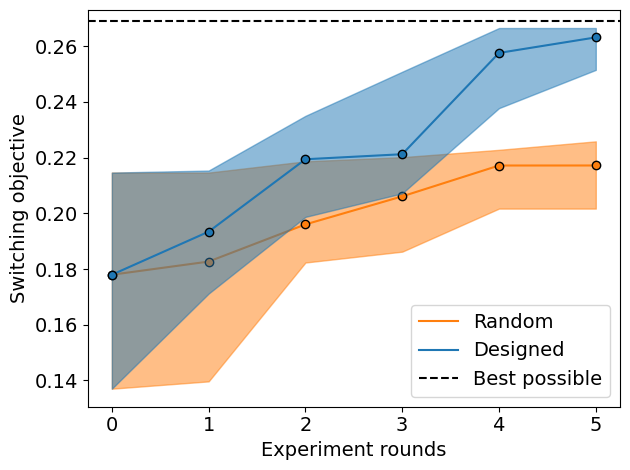

In [18]:
q25, q50, q75 = np.quantile(df_random.values, [.25, .5, .75], 1)
plt.plot(np.arange(df_results.shape[0]), q50, c='C1', label="Random", zorder=0)
plt.scatter(np.arange(df_results.shape[0]), q50, c='C1', edgecolor='k', zorder=1)
plt.fill_between(np.arange(df_results.shape[0]), q25, q75, color='C1', alpha=.5, zorder=0)

q25, q50, q75 = np.quantile(df_results.values, [.25, .5, .75], 1)
plt.plot(np.arange(df_results.shape[0]), q50, c='C0', label="Designed", zorder=2)
plt.scatter(np.arange(df_results.shape[0]), q50, c='C0', edgecolor='k', zorder=3)
plt.fill_between(np.arange(df_results.shape[0]), q25, q75, color='C0', alpha=.5, zorder=2)

plt.axhline(y=np.max(objectives), c='k', linestyle='--', label='Best possible')

plt.legend(fontsize=14, loc='lower right')
plt.xlabel("Experiment rounds", fontsize=14)
plt.ylabel("Switching objective", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.tight_layout()
plt.savefig("figures/optimization_simulation.png", dpi=300)
plt.show()